In [1]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP
from torch.optim.lr_scheduler import StepLR
from torch_DE.continuous.utils import R3_sampler,Data_handler,Loss_handler

# Convection Tutorial

This tutorial covers the basic introduction to using Torch DE for solving PINNs. Here we solve the first order pde:
$$
\frac{\partial u}{\partial t} - \beta\frac{\partial u}{\partial t} = 0
$$
$$
x \in [0,2\pi],\quad t \in [0,1]
$$

$$
u(x,0) = \sin(x)
$$
$$
u(0,t) = u(2\pi,t)
$$

This has the analytical solution:
$$
\sin(x-\beta t)
$$

For our example we will be using $\beta = 30$

In this tutorial you will learn:
1. How to set up a basic 2D domain
2. How to use the Data handler to store different groups of data points
3. Set up DE Getter for derivative extraction using autodiff
4. Use loss handler to track losses and calculate losses

# Geometry

In PINNs we often treat temporal and spatial dimensions the same, As such our domain is basically a rectangle (x is the width and time is the height). We can use the built in Domain and Rectangle functions to easily create this domain:

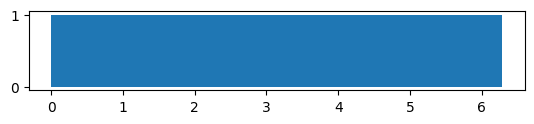

In [4]:
domain = Rectangle(((0,0),(2*torch.pi,1) ),'corners')
domain = Domain2D(base = domain)
domain.plot()

Torch Domain object automatically allows us to generate points from the domain

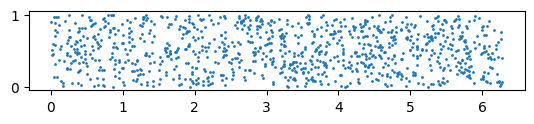

In [3]:
sampled_points = domain.generate_points(1000)
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)

# Convection PINN

## Generate BC

Torch DE uses Data_handler to store points for different regions of out geometry. It is essentially a dictionary with some extra bells and whistles (such being able to set all items to a specific device). Data__handler stores all our points that we will use as the boundary,initial and collocation points

In [4]:
#DATA
data  = Data_handler()
data['collocation points'] = domain.generate_points(1000)
data['initial condition'] = torch.stack( [torch.linspace(0,2*torch.pi,100),torch.zeros(100)],dim = -1)
data['boundary_0'] = torch.stack( [torch.zeros(100),torch.linspace(0,1,100)],dim = -1)
data['boundary_2pi'] = torch.stack( [2*torch.pi*torch.ones(100),torch.linspace(0,1,100)],dim = -1)
data.set_to_device('cuda')

Set all tensors to device cuda


## Set up network

Standard Pytorch network,optimizer and learning rate scheduler

In [5]:
#PYTORCH SETUP
torch.manual_seed(1234)
net = MLP(2,1,50,4)
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)

## Set Up DE_Getter

DE_Getter is the object by which Torch DE uses to extract the required derivatives from the network. By default we will use the autodiff method to automatically calculate gradients from the network rather than use something like finite difference.

Basic DE_getter we just neet to specify the input and output variables and the derivatives we want. For derivatives we use the underscore _ to distinguish between the dependent and independent variable of a derivative e.g. u_x $= u_x = \dfrac{\partial u}{\partial x}$. 

**Note that currently variables names can only be single letters!**

In [6]:
#SET UP DERIVATIVES
PINN = DE_Getter(net)
PINN.set_vars(['x','t'],['u'])
PINN.set_derivatives(['u_x','u_t'])

dict_keys(['u', 'u_x', 'u_t'])


c:\Users\John Su\Downloads\Py_DE\env\lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


## Losses

Torch DE has an object called Loss Handler that lets users to store the different types of losses such as initial conditions, resiudal equations boundary and other custom functions.

To initialise you only need to give the groups from your data handler. Then you can store different losses based on different groups simply using group names! Input for initial,boundary and residuals losses can be either tensors or functions that returns tensors. In this example we use the initial condition function $\sin(x)$ 

For Periodic this is slightly different and we specify the two groups to be periodic and the variable to be periodic (in this case u)

Losses takes in a data handler object and output from DE_getter and automatically applies the MSE on each loss


In [25]:
IC_func = lambda xt: torch.sin(xt[:,0])

#Residual Equation:
def convection(u_t,u_x,beta = 30,**kwargs):
    return u_t + beta*u_x

#LOSSES
losses = Loss_handler(data.group_names())
losses.add_initial_condition('initial condition',{'u':IC_func})
losses.add_residual('collocation points',{'convection':convection})
losses.add_periodic('boundary_0','boundary_2pi','u')




## Pytorch Training Loop

In [ ]:
net = net.cuda()

for i in range(50_000):
    
    data.set_to_device('cuda')
    output = PINN.calculate(data,target_group ='collocation points')
    ls = losses.calculate(data,output)
    IC_loss,BC_loss,res_loss = ls['Initial Condition'],ls['Periodic'],ls['Residual']
    loss = 100*IC_loss+ res_loss +100*BC_loss
    losses.print_losses(i)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    LR_sch.step()

    data['collocation points'] = domain.generate_points(1000)

## Compare to analytic Solution!


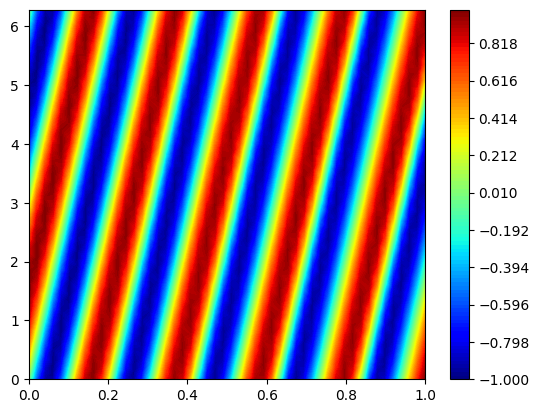

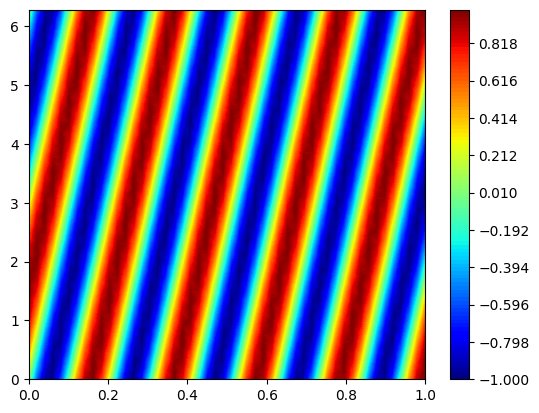

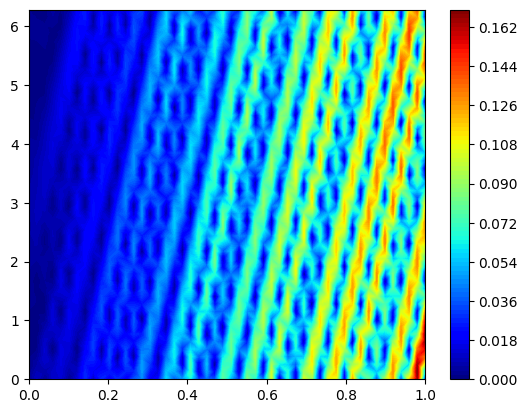

In [18]:
from matplotlib import tri
xy = torch.meshgrid(torch.linspace(0,2*torch.pi,50),torch.linspace(0,1,50))
x = xy[0].flatten()
y = xy[1].flatten()

tri_ang = tri.Triangulation(y, x)

net = net.cpu()
u = net(torch.stack([x,y],-1)).detach()
u.device

beta = 30
plt.tricontourf(tri_ang,u[:,0])
u_analytic = lambda xt: torch.sin(xt[:,0] - beta*xt[:,1])
u_a = u_analytic(torch.stack([x,y],-1))
plt.tricontourf(tri_ang,u[:,0],levels = torch.linspace(-1,1,100),cmap = 'jet')
plt.colorbar()
plt.show()
plt.tricontourf(tri_ang,u_a,levels = torch.linspace(-1,1,100),cmap = 'jet')
plt.colorbar()
plt.show()

plt.tricontourf(tri_ang,torch.abs((u_a-u[:,0])),levels = 100,cmap = 'jet')
plt.colorbar()
plt.show()


# Adding R3 Sampling To Training Loop

This is the same code but now we add the R3 sampler which retains points with high residual losses rather than resampling the entire domain in a random fashion.

Compare the error graph between with and without the sampler. Notice an order of magnitude of error lower and very little change in runtime!

In [ ]:
#PYTORCH SETUP
torch.manual_seed(1234)
net = MLP(2,1,50,4)
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)

#SET UP DERIVATIVES
PINN = DE_Getter(net)
PINN.set_vars(['x','t'],['u'])
PINN.set_derivatives(['u_x','u_t'])

IC_func = lambda xt: torch.sin(xt[:,0])

#Residual Equation:
def convection(u_t,u_x,beta = 30,**kwargs):
    return u_t + beta*u_x

#LOSSES
losses = Loss_handler(data.group_names())
losses.add_initial_condition('initial condition',{'u':IC_func})
losses.add_residual('collocation points',{'convection':convection})
losses.add_periodic('boundary_0','boundary_2pi','u')

#Sampler
sampler = R3_sampler(domain.generate_points)

net = net.cuda()

for i in range(50_000):
    
    data.set_to_device('cuda')
    output = PINN.calculate(data,target_group ='collocation points')
    ls = losses.calculate(data,output)
    IC_loss,BC_loss,res_loss = ls['Initial Condition'],ls['Periodic'],ls['Residual']
    loss = 100*IC_loss+ res_loss +100*BC_loss
    losses.print_losses(i)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    LR_sch.step()
    res = losses.loss_groups['Residual']['collocation points']['convection'](data,output)
    data['collocation points'] = sampler(data['collocation points'],res)

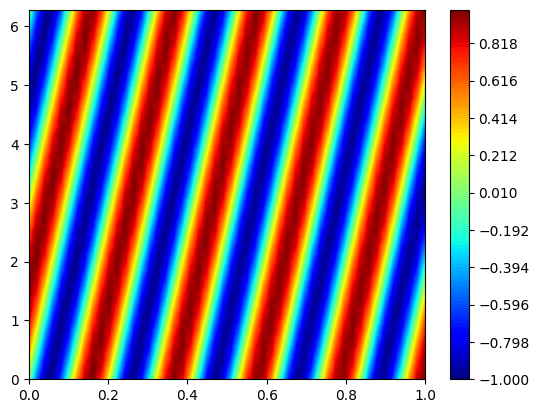

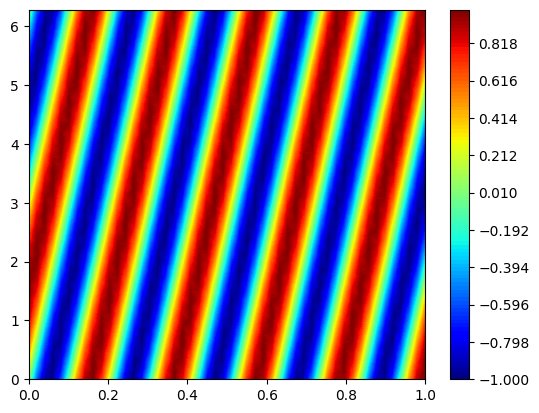

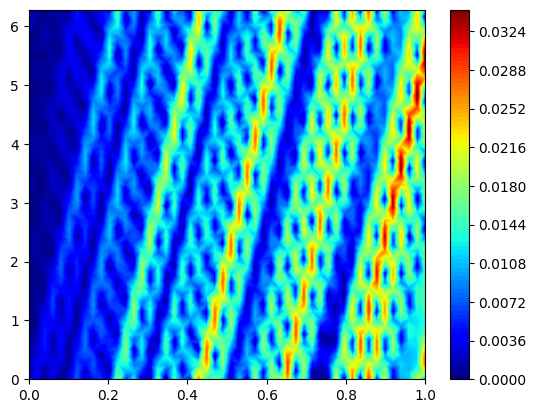

In [27]:
from matplotlib import tri
xy = torch.meshgrid(torch.linspace(0,2*torch.pi,50),torch.linspace(0,1,50))
x = xy[0].flatten()
y = xy[1].flatten()

tri_ang = tri.Triangulation(y, x)

net = net.cpu()
u = net(torch.stack([x,y],-1)).detach()
u.device

beta = 30
plt.tricontourf(tri_ang,u[:,0])
u_analytic = lambda xt: torch.sin(xt[:,0] - beta*xt[:,1])
u_a = u_analytic(torch.stack([x,y],-1))
plt.tricontourf(tri_ang,u[:,0],levels = torch.linspace(-1,1,100),cmap = 'jet')
plt.colorbar()
plt.show()
plt.tricontourf(tri_ang,u_a,levels = torch.linspace(-1,1,100),cmap = 'jet')
plt.colorbar()
plt.show()

plt.tricontourf(tri_ang,torch.abs((u_a-u[:,0])),levels = 100,cmap = 'jet')
plt.colorbar()
plt.show()